In [3]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [1]:
from tensorflow_utils.classifiers.tf_nets import MiniInception, MiniAlexNet, ResNet, DenseNet, PreTrainedModel, Augmenter, ResizeAndNormalize
from tensorflow_utils.classifiers.tf_func_nets import mini_alex_net, mini_inception, res_net, dense_net
from tensorflow_utils.classifiers.tf_layers import ConvNormalizeDrop
from tensorflow_utils.utils.keras_load_data import load_cifar10, Dataset, get_generator_for, plot_sample_images
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import time
import os
from tensorflow_utils.utils.tf_utils import *


ValueError: numpy.ufunc has the wrong size, try recompiling. Expected 192, got 216

In [6]:
def model_init_fn():
    global nets, net_name
    net = nets[net_name][0]
    inputs = nets[net_name][1]
    return net(**inputs)

In [7]:
device = '/device:GPU:0'  # Change this to a CPU/GPU as you wish!
#     device = '/cpu:0'        # Change this to a CPU/GPU as you wish!

## Load Data, Put In Appropriate Container

In [8]:
bs = 64
from_saved_imgs = False
from_generator = False

dset_names = ['train', 'val', 'test']

if from_saved_imgs:
    main_dir = '/home/abdelrhman/data/cifar_10'
    datasets = {x: generate_data_from_dir(os.path.join(main_dir, x)) for x in dset_names}
else:
    X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10(num_training=49000, augment= False, normalize= False, plot=False)
    datasets = {'train': (X_train, y_train), 'val': (X_val, y_val), 'test': (X_test, y_test)}
    if from_generator:
        datasets = {x: ImageDataGenerator().flow(*datasets[x], batch_size=bs) for x in dset_names}

(32, 32, 3)


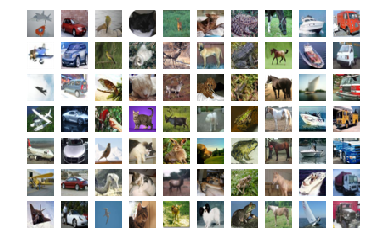

In [9]:
if from_generator or from_saved_imgs:
    plot_sample_images(*next(datasets['train']), 2, 2)
else:
    plot_sample_images(*datasets['train'], samples_per_class=7, num_classes=10)

In [10]:
save_imgs = False
if save_imgs:
    resize_and_save(X_train, y_train, size=(224, 224), start=0, base_path='/home/abdelrhman/data/cifar_10/train_aug/')
    resize_and_save(X_val, y_val, size=(224, 224), start=0, base_path='/home/abdelrhman/data/cifar_10/val/')
    resize_and_save(X_test, y_test, size=(224, 224), start=0, base_path='/home/abdelrhman/data/cifar_10/test/')

## Add Preprocessors

In [13]:
preprocess = True
preprocessor = None
size = (224, 224)

if preprocess:
    with tf.device(device):
        if from_saved_imgs:
            augmenter = Augmenter(resized_crop=None, translate_by=None, horizontal_flip=False) # apply only on train_ds.
            size = None
        else:
            augmenter = Augmenter(resized_crop=None, translate_by=None, fill_mode='constant') # apply only on train_ds.
        preprocessor = ResizeAndNormalize(resize_to=size, rescale=True)  # Fit normalized on augmented train_ds, apply on all datasets.
                              
        if from_generator or from_saved_imgs:
            x_mini_batches = [next(datasets['train'])[0] for _ in range(0, 1024//bs)]
        else:
            x_mini_batches = [X_train[i: i + bs] for i in range(0, 1024, bs)]
        
        for i, x in enumerate(x_mini_batches):
            x = augmenter(x)
            reset_state = True if i == 0 else False
            preprocessor.adapt_normalizer(x, adapt_to_resized=True, reset_state=reset_state)
        
        # resized_images = augmenter(X_train[:500], training=True)
    # plot_sample_images(resized_images.numpy(), y_train[:500], 3, 3)

    mean = preprocessor.normalizer.mean.numpy()
    std = np.sqrt(preprocessor.normalizer.variance.numpy())
    print(mean)
    print(std)

[0.49069512 0.4830753  0.4452141 ]
[0.23965254 0.23693386 0.25644553]


## Perform the Input Pipline using tf.data

In [14]:
use_tf_dset = True
if use_tf_dset:
    if from_generator or from_saved_imgs:
        datasets_pipeline = {x: prepare_dataset(generator=lambda : datasets[x],
                                                batch_size=bs, preprocessor=preprocessor,
                                                augmenter=augmenter if x=='train' else None, 
                                                shuffle=False, buffered_prefetching=True) for x in dset_names}
    else:
        datasets_pipeline = {x: prepare_dataset(data=datasets[x], batch_size=bs, preprocessor=preprocessor,
                                                augmenter=augmenter if x=='train' else None, 
                                                shuffle=False, buffered_prefetching=True) for x in dset_names}


W1204 19:38:38.361597 140586515281664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
(224, 224, 3)


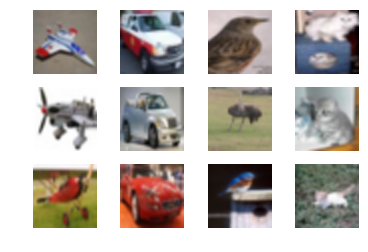

In [15]:
if use_tf_dset:
    images , labels = next(iter(datasets_pipeline['train']))
    images, labels = images.numpy(), labels.numpy()
    plot_sample_images(images, labels, samples_per_class=3, num_classes=4, mean=mean, std=std, dtype='float32')

In [16]:
shape = (224, 224, 3)
num_epochs = 10 if from_saved_imgs else 20
learning_rate = 0.001
lr_decay = 0.5
decay_every = 'val_acc_plateau'
d, l1, l2 = 0.01, 0, 0
reg = {'l1': l1, 'l2': l2, 'drop_prop': d}

nets = {
    'MiniInception': (MiniInception, reg),
    'NaiveMiniInception': (MiniInception, {'params': (64, 32, 16), 'naive': True, **reg}),
    'MiniAlexAffine': (MiniAlexNet, {'affine_size': [512] * 2, **reg}),
    'MiniAlexGavg': (MiniAlexNet, {'use_avg_pool': True, **reg}),
    'NaiveResNet3_2': (ResNet, {'reduce_every': 3, 'repeats': 2, **reg}),  # 9 blocks = 18 learnable layers
    'NaiveResNet2_3': (ResNet, {'reduce_every': 2, 'repeats': 3, **reg}),  # 8 blocks = 16 learnable layers
    'NaiveResNet2_2': (ResNet, {'reduce_every': 2, 'repeats': 2, **reg}),  # 6 blocks = 12 learnable layers
    'NaiveResNet2_1': (ResNet, {'reduce_every': 2, 'repeats': 1, **reg}),  # 4 blocks = 8 learnable layers
    'dense_net_6_12_32_k12': (DenseNet, {'dense_layers': (6, 12, 32), 'k': 12, 'compactness': 0.5, 'pool': 'avg', **reg}),
    'pre_trained_densenet121': (PreTrainedModel, {'model': 'densenet121', 'shape': shape, 'drop_prop': d}),
    'pre_trained_densenet121_finetuned_4th': (PreTrainedModel, {'model': 'densenet121', 'shape': shape, 'drop_prop': d, 
    'fine_tune': -7*16-2})
}

net_name = 'pre_trained_densenet121_finetuned_4th'

model_name = '{}_l1={}_l2={}_drop={}'.format(net_name, l1, l2, d)

dir_name = "/home/abdelrhman/loggings/"

run_name = dir_name + model_name +\
           '_lr{}_decay{}_every{}_'.format(learning_rate, lr_decay, decay_every) + \
           'hflip_zpad_crop' + time.strftime("run_%Y_%m_%d-%H_%M_%S")

dot_img_file = run_name + '/model_img.png'

print(run_name)

/home/abdelrhman/loggings/pre_trained_densenet121_finetuned_4th_l1=0_l2=0_drop=0.01_lr0.001_decay0.5_everyval_acc_plateau_hflip_zpad_croprun_2020_12_04-19_39_48


In [17]:
# Define the Keras TensorBoard callback.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=run_name)
lr_on_plateau_decay = tf.keras.callbacks.ReduceLROnPlateau('val_sparse_categorical_accuracy',
                                                           lr_decay, patience=1, verbose=1)

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = run_name + "/training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    period=1,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

W1204 19:39:56.764904 140586515281664 callbacks.py:1184] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


In [ ]:
with tf.device(device):
    load_saved_model = False
    if load_saved_model:
        run_name = dir_name + 'pre_trained_densenet121_l1=0_l2=0_drop=0.01_lr0.001_decay0.5_everyval_acc_plateau_hflip_zpad_croprun_2020_09_03-20_34_33'

        model = tf.keras.models.load_model(run_name + '/model')
    else:
        # Use this when u need to use the subclass form of the model.
        # model = model_init_fn()

        # Use this when u need to use the functional form of the model (can visualize, summarize and optimize ^_^)
        if use_tf_dset:
            aug = None
        elif preprocess:
            aug = preprocessor
        model = model_init_fn().get_functional_model((None, *shape), preprocessor=aug)
    
    print(model.summary())
    
    load_from_ckpt = False
    if load_from_ckpt:
        prev_run_name = dir_name + 'pre_trained_densenet121_l1=0_l2=0_drop=0.01_lr0.001_decay0.5_everyval_acc_plateau_hflip_zpad_croprun_2020_09_03-18_26_08'
        update_model_weights_from_ckpt(model, prev_run_name)
    

    model.compile(optimizer='adam',
          loss='sparse_categorical_crossentropy',
          metrics=[tf.keras.metrics.sparse_categorical_accuracy])
    
    if from_generator or from_saved_imgs and not use_tf_dset:
        # fits the model on batches with real-time data augmentation:
        model.fit(datasets['train'], epochs=num_epochs, validation_data=datasets['val'], verbose=2,
                  callbacks=[tensorboard_callback, cp_callback])
    elif use_tf_dset:
        model.fit(datasets_pipeline['train'], epochs=num_epochs, validation_data=datasets_pipeline['val'], verbose=1,
                  callbacks=[tensorboard_callback, cp_callback])
    else:
        model.fit(*datasets['train'], batch_size=bs, epochs=num_epochs,
          validation_data=datasets['val'], verbose=2, callbacks=[tensorboard_callback, cp_callback])
        
    model.save(run_name + '/model')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                10250     
Total params: 7,047,754
Trainable params: 2,170,378
Non-trainable params: 4,877,376
_________________________________________________________________
None
Epoch 1/20
  1/766 [..............................] - ETA: 0s - loss: 2.4769 - sparse_categorical

W0904 06:30:49.012394 139968291010304 deprecation.py:323] From /home/abdelrhman/anaconda3/envs/cs231n/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


766/766 [==============================] - ETA: 0s - loss: 0.3139 - sparse_categorical_accuracy: 0.8923
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.91300, saving model to /home/abdelrhman/loggings/pre_trained_densenet121_finetuned_4th_l1=0_l2=0_drop=0.01_lr0.001_decay0.5_everyval_acc_plateau_hflip_zpad_croprun_2020_09_04-06_30_34/training_2/cp-0001.ckpt
766/766 [==============================] - 218s 285ms/step - loss: 0.3139 - sparse_categorical_accuracy: 0.8923 - val_loss: 0.2597 - val_sparse_categorical_accuracy: 0.9130
Epoch 2/20
766/766 [==============================] - ETA: 0s - loss: 0.1639 - sparse_categorical_accuracy: 0.9423
Epoch 00002: val_sparse_categorical_accuracy improved from 0.91300 to 0.91500, saving model to /home/abdelrhman/loggings/pre_trained_densenet121_finetuned_4th_l1=0_l2=0_drop=0.01_lr0.001_decay0.5_everyval_acc_plateau_hflip_zpad_croprun_2020_09_04-06_30_34/training_2/cp-0002.ckpt
766/766 [==============================] - 217s 283

In [ ]:
with tf.device(device):
    
    load_saved_model = False
    if load_saved_model:
        run_name = dir_name + \
        'pre_trained_densenet121_l1=0_l2=0_drop=0.01_lr0.001_decay0.5_everyval_acc_plateau_hflip_zpad_croprun_2020_08_30-00_18_24'

        model = tf.keras.models.load_model(run_name + '/model')
    
    if from_generator or from_saved_imgs:
        model.evaluate(datasets['test'], callbacks=[tensorboard_callback])
    elif use_tf_dset:
        model.evaluate(datasets_pipeline['test'], callbacks=[tensorboard_callback])
    else:
        model.evaluate(X_test, y_test, batch_size=bs, callbacks=[tensorboard_callback])
    